# 1.1 Radial velocity analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023 exercise 1

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 17.4.2023

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).


## (The absolute basics of) radial velocities

A planet orbiting a star causes the star to [move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity,
and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

Doppler_Shift_vs_Time.svg



A planet with a mass $M_\mathrm{p}$ orbiting a star with a mass $M_\star$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}},
$$

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$, and $M_\star$ we can solve for the minimum planetary mass $M_\mathrm{p} \sin i$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.

$P$ needs to be inserted in BJD.

## (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a *parameter estimation* problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://ui.adsabs.harvard.edu/link_gateway/2018haex.bookE.149P/EPRINT_PDF) and the references therein.

## Initialisation

In [109]:
%matplotlib inline

In [110]:
!pip install pandas
!pip install corner
!pip install pytransit
!pip install celerite
!pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
import pandas as pd
import astropy.units as u

from matplotlib.pyplot import subplots, setp, rc, Rectangle, plot, subplot, hist
from numpy import argmax, median, sin, arctan, pi, std, array
from astropy.table import Table
from astropy.timeseries import LombScargle
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [113]:
rv_data = Table.read('/content/drive/MyDrive/Máster/Exoplanetas y Exobiología/data/wasp_12b_yee_2019.dat', format='ascii.cds')

It's important to understand what sort of data we're dealing with, so we begin by displaying the table header and the five first rows.

In [114]:
rv_data[:]  

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727
2455559.927852,111.001,3.186
2455636.843302,-143.932,2.627
2455671.769904,-107.997,2.446


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

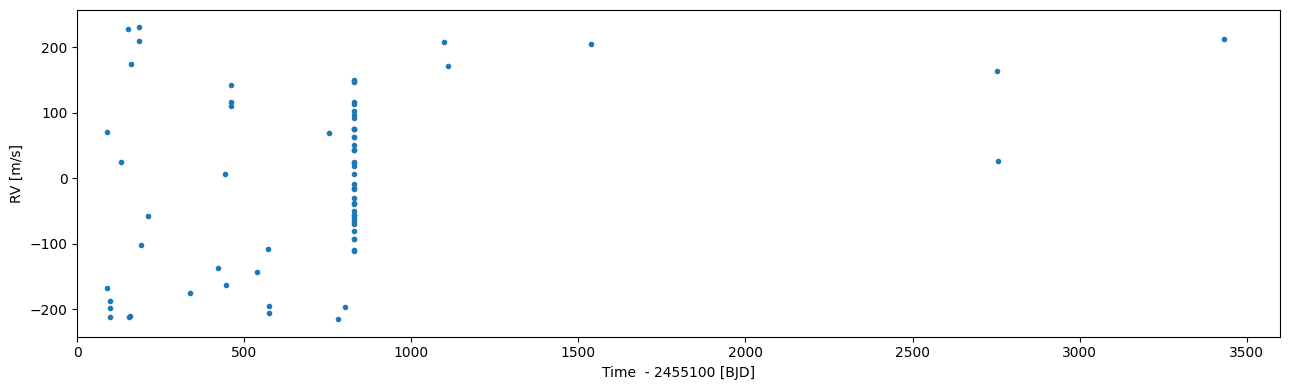

In [115]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>

1. Try to describe the logic behind the time sampling of the RV observations.

- The points are data taken in different moments. The 'apparent' straight line seems to represent a sudden change in the radial velocity. However, when looking at the x axis, we see that it goes from, more or less, the 25th of September of 2009 to the 26th of April of 2019: a span of 10 years. If we zoom in the 'straight' line, we see that the data was taken the 2nd of January of 2012, from 6am to 13am: around 7 hours. That is why it looks like a straight line when it is represented in a range of 10 years.

2. Plot below the RV observations as a function of time focusing on the densely-sampled time-span.

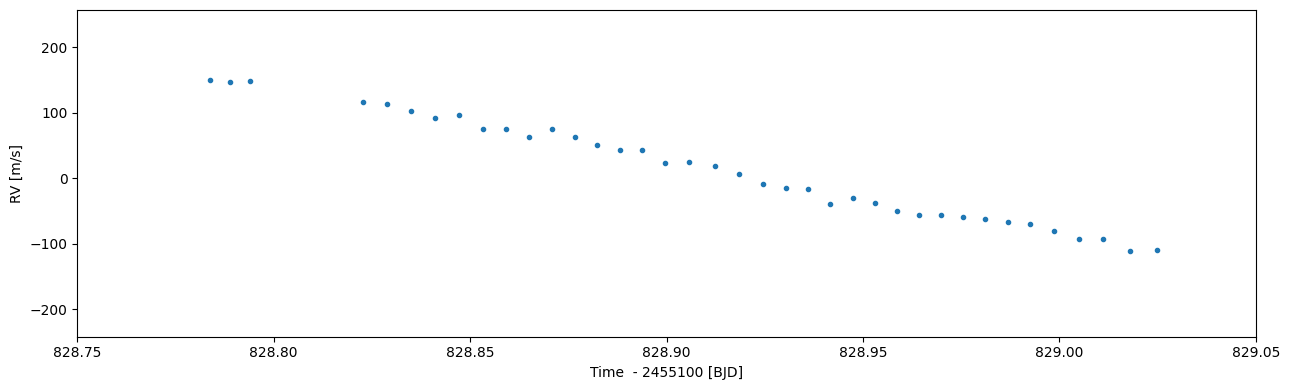

In [116]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.75, 829.05))
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [117]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

Next, we use the `LombScargle.autopower` to calculate the periodogram. We restrict the search to $0.5 < P < 5$ days.

In [118]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [119]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

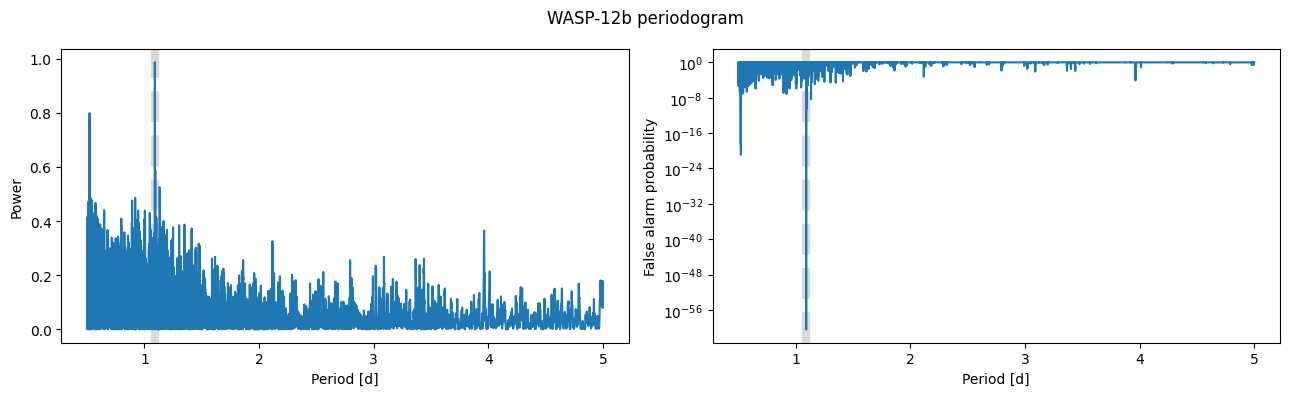

In [120]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

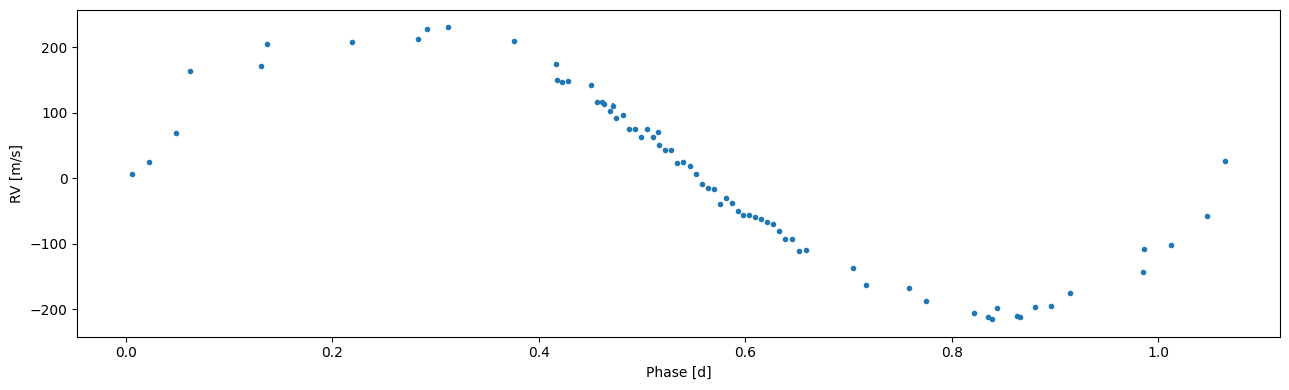

In [121]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [122]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

The second parameter represents the number of planets the system is supposed to have.

In [123]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

The parameters are

- `tc_1`: transit center [BJD]
- `p_1`: orbital period [d]
- `secw_1`: $\sqrt{e} \cos\omega$, where $e$ is the eccentricity and $\omega$ the argument of periastron
- `sesw_1`: $\sqrt{e} \sin\omega$
- `rv_shift_0`: systemic velocity [m/s]
- `rv_err_0`: additional white noise [m/s]
- `rv_k_1` RV semiamplitude [m/s]
- `rv_slope`: additional linear slope

N = Normal Prior \
U = Uniform Prior

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [124]:
lpf.set_prior('tc_1', 'NP', 2458480.65, 0.02)  # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', 1.09, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)

In [125]:
lpf.ps

[  0 |G| tc_1           N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.09, σ = 0.1)                     [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

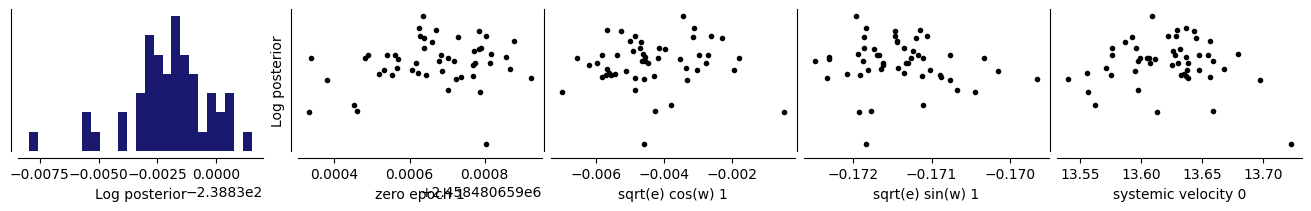

In [126]:
lpf.optimize_global(2000)

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:285: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(self._timea[m] + self._tref, rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


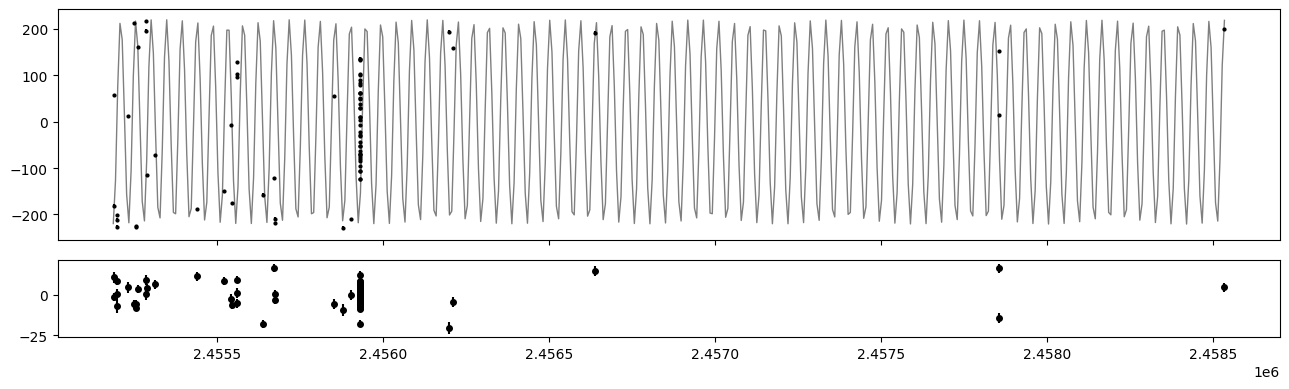

In [127]:
lpf.plot_rv_vs_time();

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


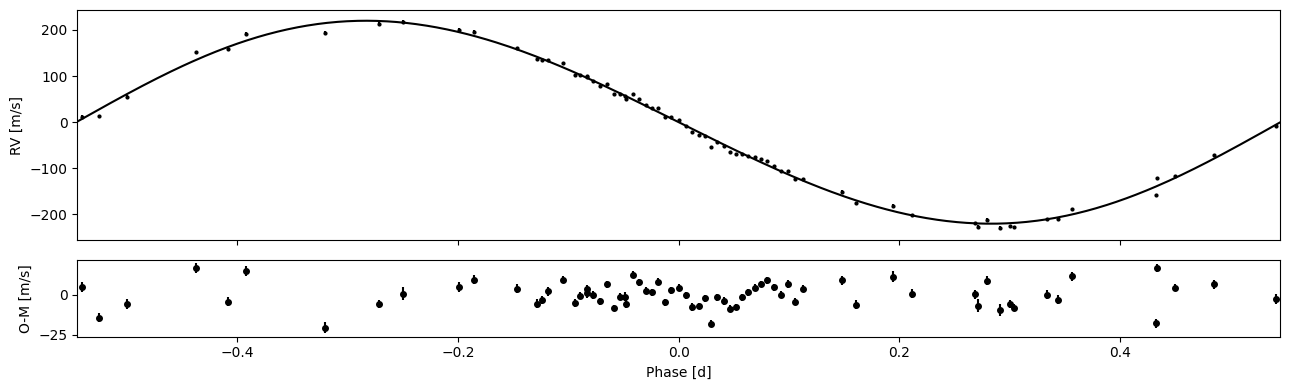

In [128]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [129]:
lpf.sample_mcmc(niter=2000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]

The *emcee* sampler uses an ensemble of MCMC chains to sample the posterior. This means that we have many chains running in parallel. We can plot the traces of each chain to see how the chain population behaves in time.

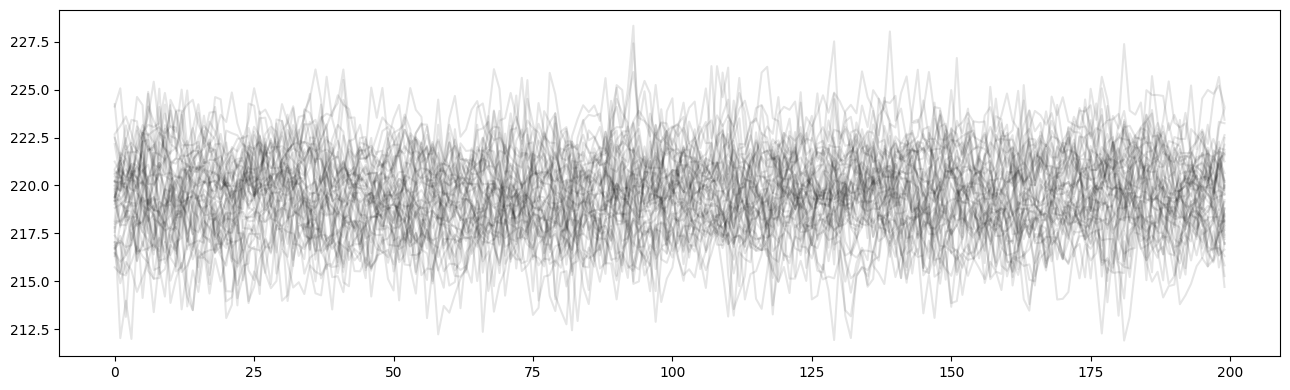

In [130]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:285: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(self._timea[m] + self._tref, rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


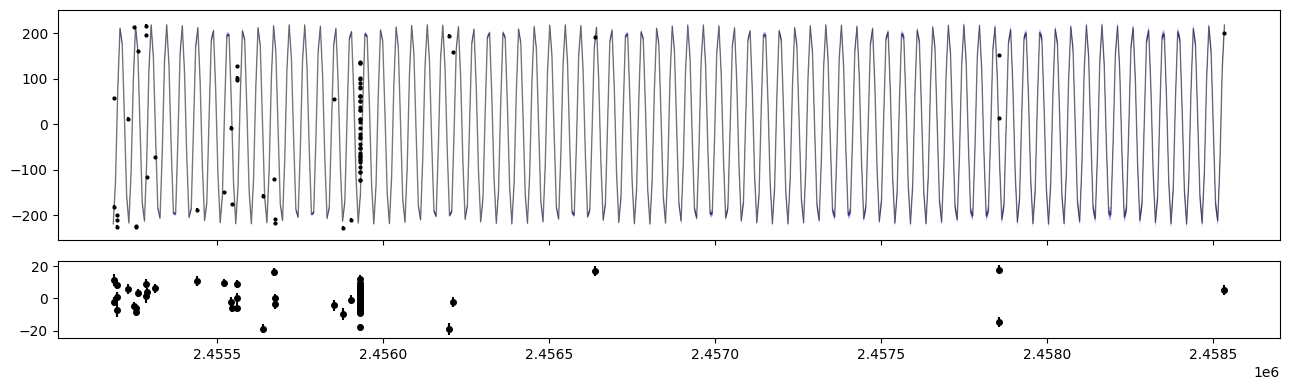

In [131]:
lpf.plot_rv_vs_time('mcmc');

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


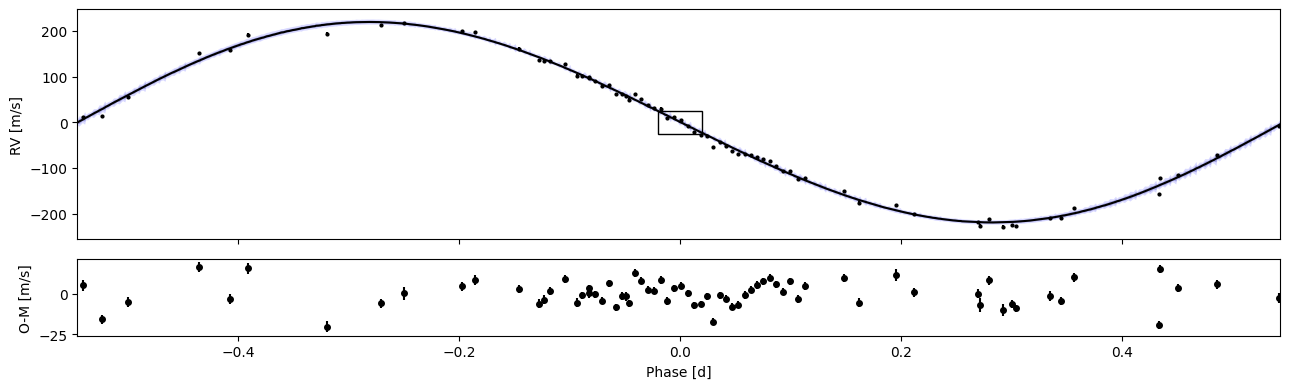

In [132]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

/usr/local/lib/python3.10/dist-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


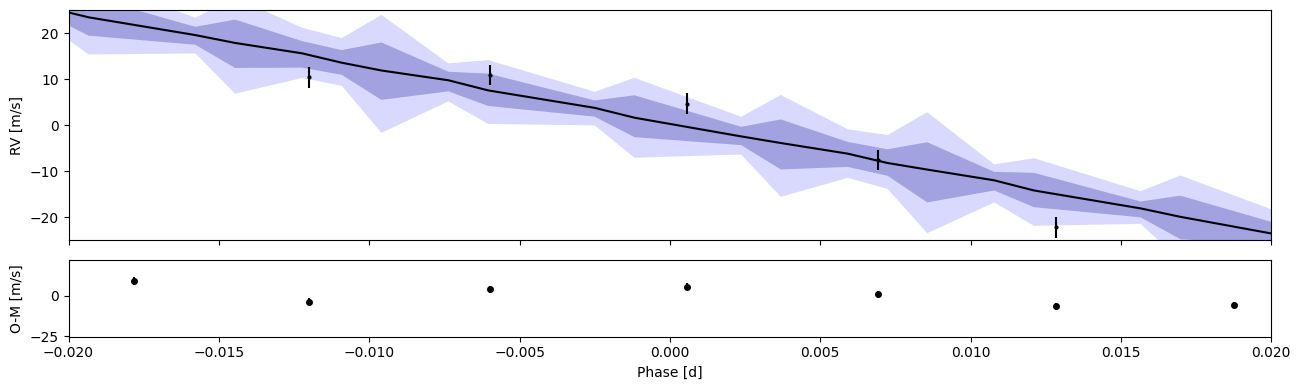

In [133]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [134]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,2.458481e+06,1.091424,0.016430,-0.184509,10.751286,9.750316,217.987478,0.000775
1,2.458481e+06,1.091424,0.021579,-0.181447,10.638338,10.128652,218.126990,0.001029
2,2.458481e+06,1.091422,0.016335,-0.162925,11.120144,9.307031,218.443853,0.000932
3,2.458481e+06,1.091423,0.027764,-0.148007,11.855966,8.084515,219.603712,0.001169
4,2.458481e+06,1.091422,-0.000299,-0.127808,10.752134,8.157998,216.406185,0.001912
...,...,...,...,...,...,...,...,...
9995,2.458481e+06,1.091423,-0.021913,-0.172872,12.538731,7.145523,220.349822,0.000843
9996,2.458481e+06,1.091423,-0.015437,-0.181195,11.856714,7.117352,221.511047,0.000501
9997,2.458481e+06,1.091423,0.045684,-0.145330,12.830225,7.370482,220.732409,0.001996
9998,2.458481e+06,1.091422,0.045497,-0.152039,12.848747,7.494436,219.974545,0.001214


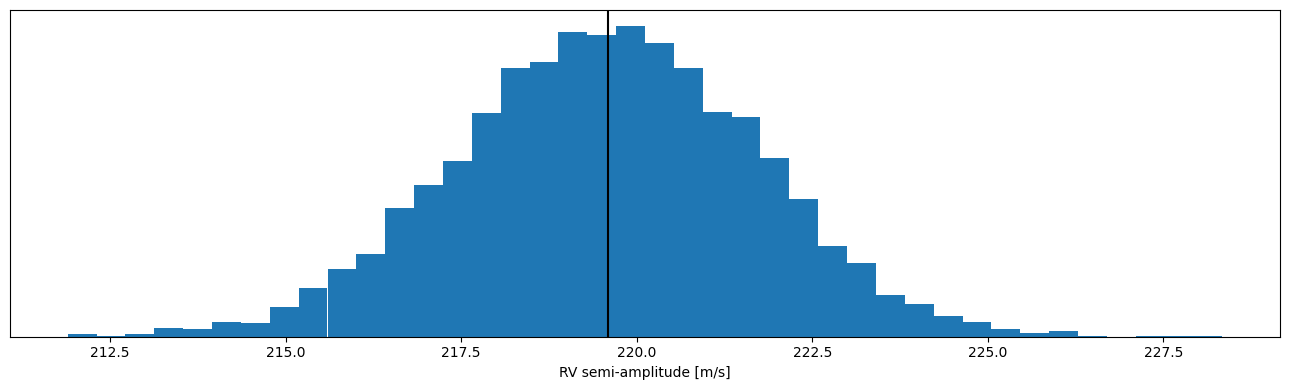

In [135]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

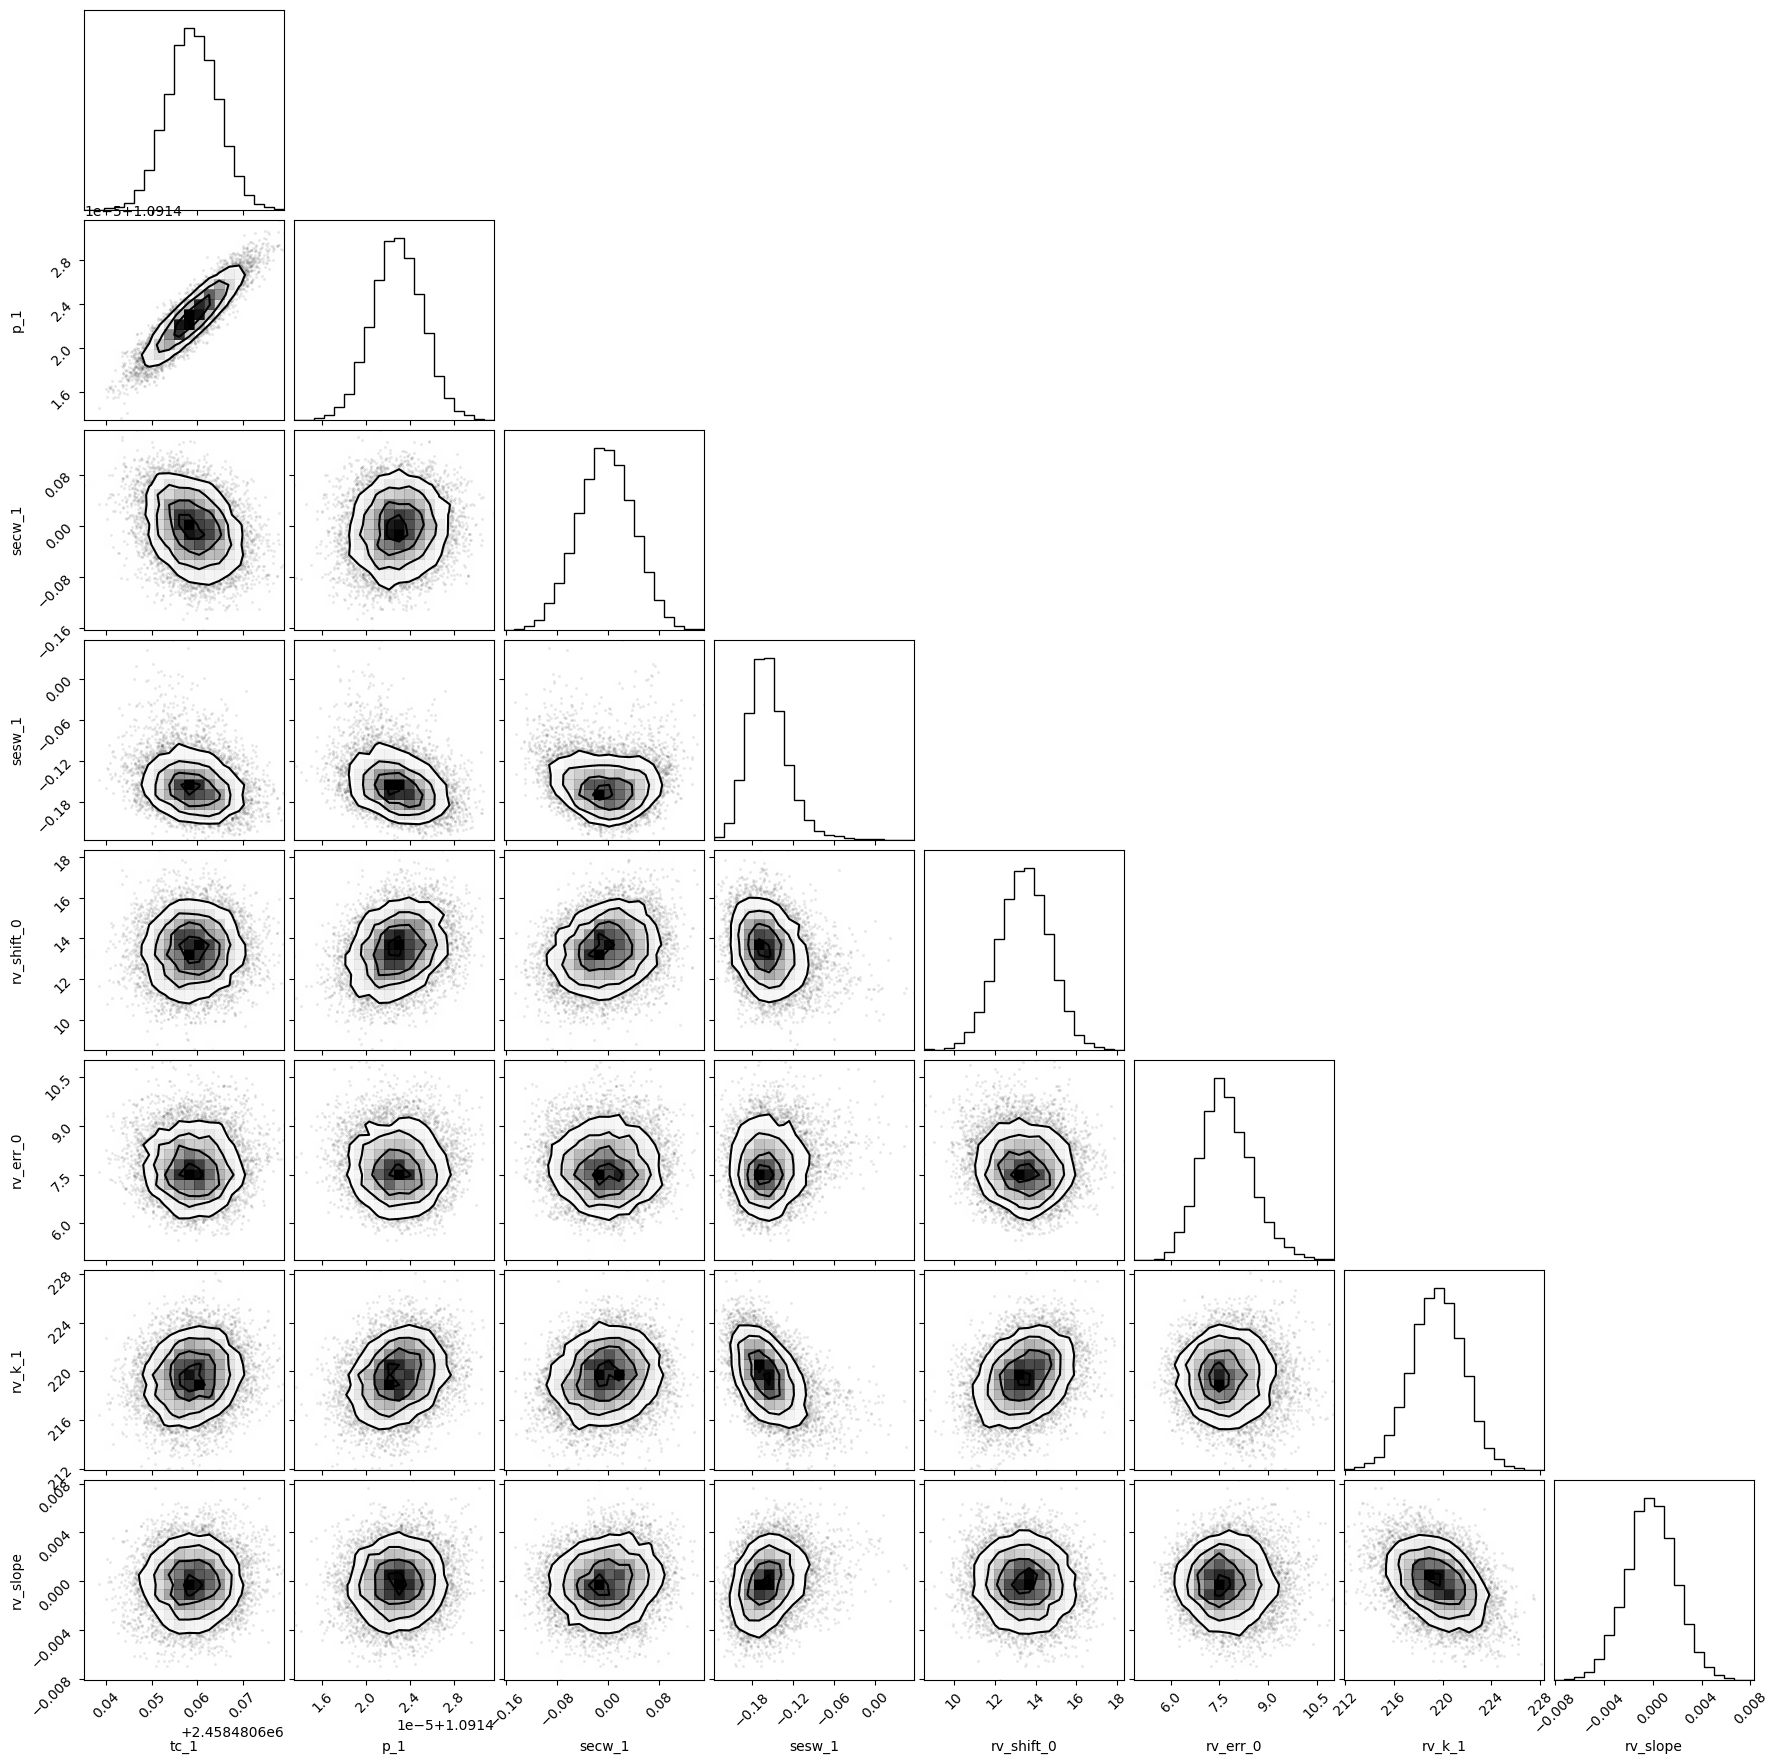

In [136]:
corner(df, labels=df.columns);

### <span style="color:darkblue">Questions and exercises</span>

1. **What is the minimum mass ($m\sin i$) of WASP-12b assuming $e=0$? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.**

> For the period, I have taken the value of the posterior. All the posteriors have the same value so there is no need to get the mean value.
  $P = 1.091422\ days = 1.091422\cdot 86400\ s$.
  
> For the eccentricity: The exercise itself determines $e=0$.

> For the mass of the star: $M_\ast = 2.685 \cdot 10^{30}\ kg = 1.35\ M_\odot$ ([Wikipedia](https://es.wikipedia.org/wiki/WASP-12))

> The gravitational constant $G = 6.67\cdot 10^{-11} N m^{2} Kg^{-2}$ ([Wikipedia](https://en.wikipedia.org/wiki/Gravitational_constant))

> We will calculate a mass for each sample and then take the median of that distribution.

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}} \approx \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{M_\star^{2/3}},
$$
\
$$
M_p\sin i= K\cdot M_\ast^{2/3}\left(\frac{P}{2\pi G}\right)^{1/3}
$$
\
$$
M_p \sin i = (2.58 \pm 0.02)\cdot 10^{27}\ Kg = (1.36 \pm 0.01)\ M_J
$$


> where $M_J$ is the mass of Jupyter $M_J = 1.898\cdot 10^{27}\ Kg$ ([Wikipedia](https://es.wikipedia.org/wiki/J%C3%BApiter_(planeta))).


In [137]:
##### MINIMUM MASS OF THE PLANET #####

M_jup = 1.898*10**27  #Kg
G = 6.67*10**(-11)    #N·m²/Kg²
P = 1.091422          #days
M_star = 2.68*10**30  #Kg


M_min = df['rv_k_1']*(M_star)**(2/3)*(P*86400/(2*pi*G))**(1/3)


print('The minimum mass of the planet is: %g Kg = %g M_jupiter' %(median(M_min),median(M_min)/M_jup))
print('The uncertainty in the determination of the mass of the planet is: %g Kg = %g M_jupiter' %(std(M_min),std(M_min)/M_jup))

The minimum mass of the planet is: 2.57693e+27 Kg = 1.35771 M_jupiter
The uncertainty in the determination of the mass of the planet is: 2.50004e+25 Kg = 0.013172 M_jupiter


2. **What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?**

> Using the expression in the previous exercise:

$$
K \approx \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{M_\star^{2/3}}
$$

> Setting $M_p \sin i=M_{earth} = 5.97\cdot10^{24}\ Kg$ ([Wikipedia](https://es.wikipedia.org/wiki/Tierra)), the orbital period $P = 365$ days and having the values for the mass of the star WASP-12 $M_p$ and the constant $G$ (same as in previous exercise), the RV semi-amplitude has been determined.

$$
K \approx 0.0733\ m/s
$$

In [138]:
##### RV SEMI-AMPLITUDE #####

P_earth = 365     #days
M_e = 5.97*10**24 #Kg

K = (2*pi*G/(P_earth*86400))**(1/3)*(M_e/M_star**(2/3))

print('The RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days would be: %.4f m/s' %K)

The RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days would be: 0.0733 m/s


3. **We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?**

> First the argument of periastron $\omega$ is determined and then, the eccentricity $e$ can be calculated.

> $\hspace{2cm} \omega = arc\,tan\left(\frac{\sqrt{e} \sin\omega}{\sqrt{e}\cos\omega}\right)\hspace{2cm}\rightarrow\hspace{2cm}  e = \frac{(\sqrt{e} \sin\omega)^{2}}{sin^{2}\omega}$


4. **Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.**

> Since the function $\texttt{arctan}$ does not differentiate between the second and fourth sector (the tangents of the angles in both sectors have negative values) we must add $180\ º$ to the negative angles.

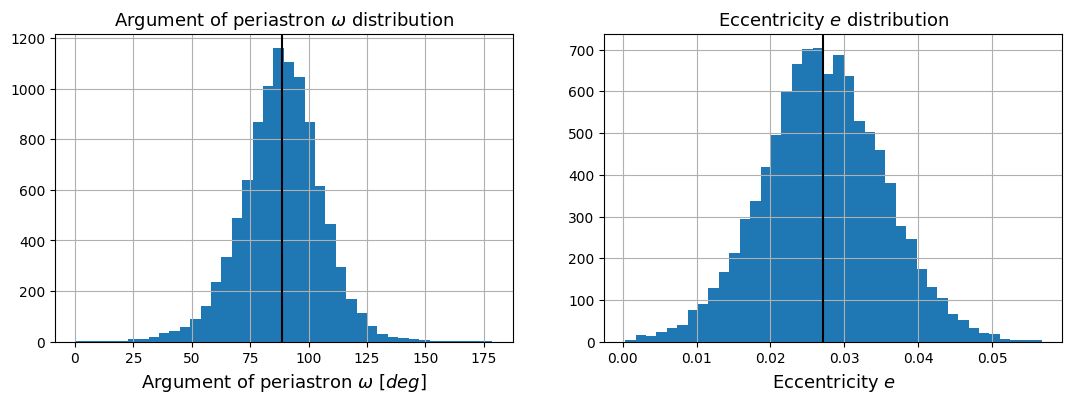

In [139]:
##### e AND w #####

W = []

for i in range(len(df.sesw_1)):
  w[i] = arctan(df.sesw_1[i]/df.secw_1[i])*180/pi
  if w[i] < 0:
    w[i] = w[i] + 180
  W.append(w[i])

W = array(W)
e = (df.sesw_1**2)/(sin(W*pi/180)**2)

fig1, (ax1, ax2) = subplots(1,2)

ax1.hist(W, bins=40)
ax1.axvline(median(W), c='k')
ax1.set_title(r'Argument of periastron $\omega$ distribution', fontsize=13)
ax1.set_xlabel(r'Argument of periastron $\omega\ [deg]$', fontsize=13)
ax1.grid()
ax1.tick_params(axis='x', labelsize=10, color='black')
ax1.tick_params(axis='y', labelsize=10, color='black')

ax2.hist(e, bins=40)
ax2.axvline(median(e), c='k')
ax2.set_title(r'Eccentricity $e$ distribution', fontsize=13)
ax2.set_xlabel(r'Eccentricity $e$', fontsize=13)
ax2.grid()
ax2.tick_params(axis='x', labelsize=10, color='black')
ax2.tick_params(axis='y', labelsize=10, color='black')

---

<center>&copy;2023 Hannu Parviainen</center>